In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception  # Changed to Xception
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import kagglehub

In [3]:
# Download the latest dataset version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/lfw-dataset


In [4]:
# Define the folder containing images
image_folder = os.path.join(path, "lfw-deepfunneled")  # Update if folder name differs

In [5]:
# List all images in the dataset folder
image_files = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} image files.")

Found 13233 image files.


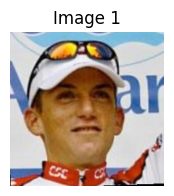

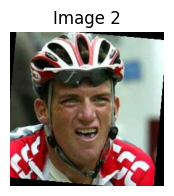

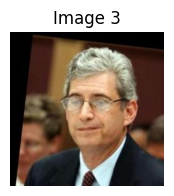

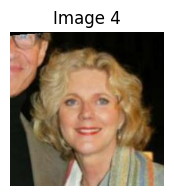

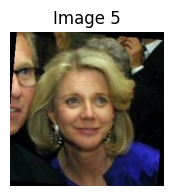

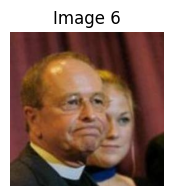

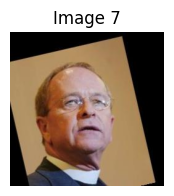

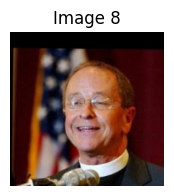

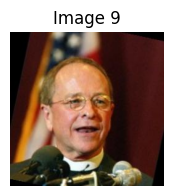

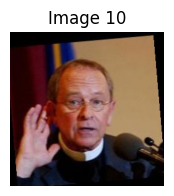

In [6]:
# Display the first ten images
for i, img_path in enumerate(image_files[:10]):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.imshow(img_rgb)
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.show()

In [7]:
# Preprocessing with Data Augmentation
def preprocess_images(image_paths, target_size=(224, 224)):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    images = []
    labels = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        images.append(img)
        label = img_path.split('/')[-2]
        labels.append(label)

    return np.array(images), np.array(labels)

In [8]:
# Preprocess Images
images, labels = preprocess_images(image_files[:6000])
print("Processed images shape:", images.shape)
print("Unique labels:", set(labels))

Processed images shape: (6000, 224, 224, 3)
Unique labels: {'John_Mayer', 'Gordon_Cooper', 'Gerhard_Schroeder', 'Bobby_Bowden', 'Bertrand_Delanoe', 'Courtney_Cox', 'Serge_Klarsfeld', 'Giancarlo_Fisichella', 'Randy_Johnson', 'Kevin_Borseth', 'Reina_Hayes', 'Shane_Phillips', 'Kai-Uwe_Ricke', 'Michael_Piuze', 'Bill_Nelson', 'Eliott_Spitzer', 'James_Spalding', 'Timothy_Goebel', 'Joe_Dumars', 'Jim_Harrick', 'Roberto_Marinho', 'Brigitte_Boisselier', 'Daisy_Fuentes', 'Claire_Hentzen', 'William_Ford_Jr', 'Tyron_Garner', 'Graeme_Lloyd', 'Wan_Yanhai', 'Thomas_Bjorn', 'Tom_Izzo', 'Hilmi_Akin_Zorlu', 'Greg_Rusedski', 'Dave_Lewis', 'Pascal_Lamy', 'Perri_Shaw', 'Mukhtar_Alytnbayev', 'Barry_Alvarez', 'Leticia_Dolera', 'Saeed_Anwar', 'Alvaro_Silva_Calderon', 'Yusuf_Misbac', 'Francis_Ford_Coppola', 'Almeida_Baptista', 'Richard_Reid', 'Venus_Williams', 'James_Robertson_Jr', 'Sean_Astin', 'Silvio_Berlusconi', 'Hussein_Malik', 'Odai_Hussein', 'Joey_Buttafuoco', 'Bilal_Erdogan', 'Karen_Clarkson', 'Pedro_Ve

In [10]:
# Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)
print("Encoded labels shape:", categorical_labels.shape)

Encoded labels shape: (6000, 2384)


In [11]:
# Splitting Dataset
X_train, X_val, y_train, y_val = train_test_split(images, categorical_labels, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (4800, 224, 224, 3)
Validation set size: (1200, 224, 224, 3)


In [12]:
# Model Fine-Tuning with Xception
def create_xception_model(input_shape=(224, 224, 3), num_classes=len(set(labels))):
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    for layer in base_model.layers[-40:]:
        layer.trainable = True

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Adding dropout to prevent overfitting
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = create_xception_model()
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 73,465,208 (280.25 MB)

 Trainable params: 73,410,680 (280.04 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [13]:
# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower initial learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Training with Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Increase epochs with early stopping
    batch_size=16,  # Adjust as per memory availability
)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 120s 251ms/step - accuracy: 0.0860 - loss: 7.2309 - val_accuracy: 0.1842 - val_loss: 6.2437
Epoch 2/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.1994 - loss: 5.8196 - val_accuracy: 0.2467 - val_loss: 5.8913
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.2699 - loss: 5.0244 - val_accuracy: 0.2900 - val_loss: 5.7867
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 74s 248ms/step - accuracy: 0.3510 - loss: 4.1955 - val_accuracy: 0.3133 - val_loss: 5.7189
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.4398 - loss: 3.3491 - val_accuracy: 0.3208 - val_loss: 5.8948
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.5291 - loss: 2.6133 - val_accuracy: 0.3267 - val_loss: 6.1501
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.6512 - loss: 1.8070 - val_accuracy: 0.3400 - val_loss: 6.5195
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 75s 249ms/step - accuracy: 0.7507 - loss: 

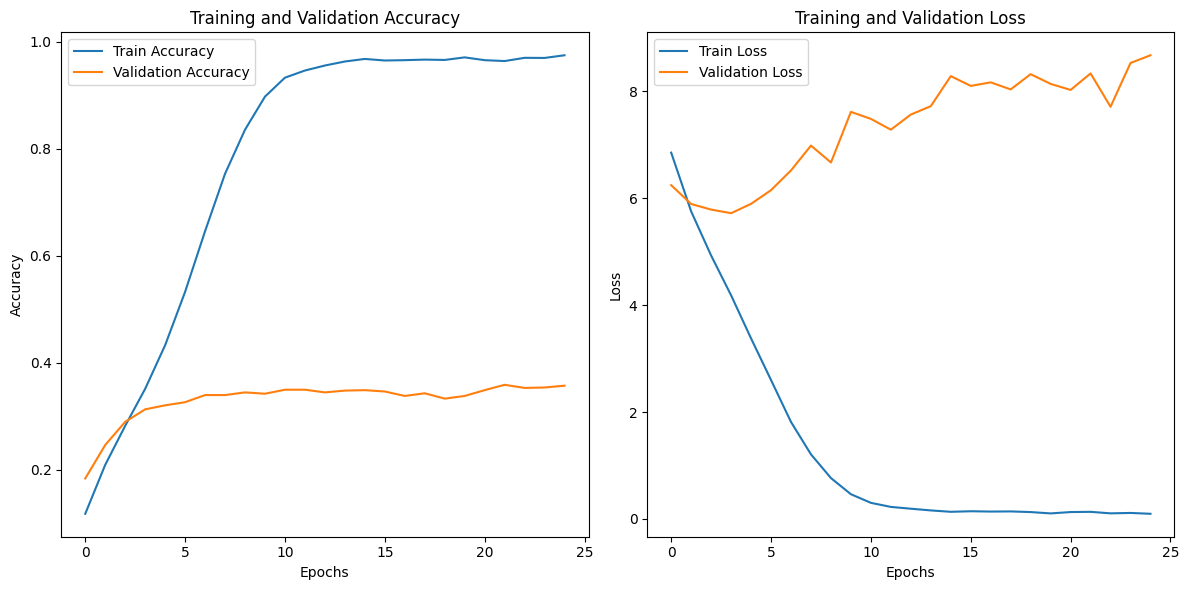

In [15]:
# Evaluation Metrics Section
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
First 50 Correct Predictions:
Index: 1, True Label: 950, Predicted Label: 950
Index: 2, True Label: 427, Predicted Label: 427
Index: 4, True Label: 2097, Predicted Label: 2097
Index: 5, True Label: 1049, Predicted Label: 1049
Index: 7, True Label: 427, Predicted Label: 427
Index: 10, True Label: 225, Predicted Label: 225
Index: 11, True Label: 1110, Predicted Label: 1110
Index: 12, True Label: 158, Predicted Label: 158
Index: 13, True Label: 1030, Predicted Label: 1030
Index: 17, True Label: 1645, Predicted Label: 1645
Index: 19, True Label: 427, Predicted Label: 427
Index: 21, True Label: 2300, Predicted Label: 2300
Index: 24, True Label: 917, Predicted Label: 917
Index: 27, True Label: 775, Predicted Label: 775
Index: 28, True Label: 152, Predicted Label: 152
Index: 30, True Label: 775, Predicted Label: 775
Index: 35, True Label: 427, Predicted Label: 427
Index: 36, True Label: 1186, Predicted Label: 1186
Index: 38, True Label: 775, Predicted 

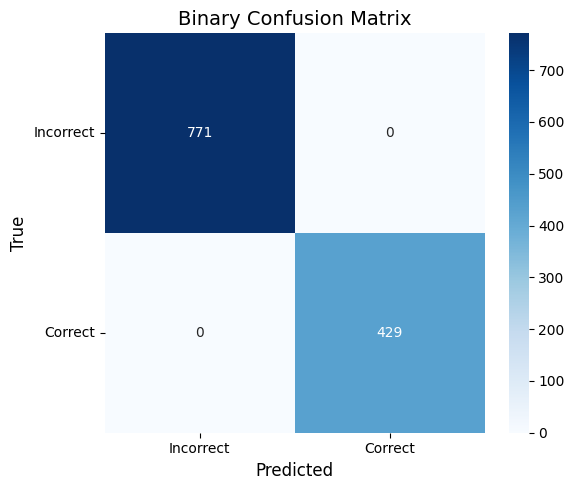

Classification Report:
                                  precision    recall  f1-score   support

                        AJ_Cook       0.00      0.00      0.00         0
                 Abdoulaye_Wade       0.00      0.00      0.00         1
                   Abel_Pacheco       0.00      0.00      0.00         1
                   Adam_Herbert       0.00      0.00      0.00         1
                   Adam_Sandler       0.00      0.00      0.00         1
                 Adel_Al-Jubeir       0.00      0.00      0.00         1
          Adolfo_Aguilar_Zinser       0.00      0.00      0.00         0
           Adolfo_Rodriguez_Saa       0.00      0.00      0.00         1
                  Ahmed_Chalabi       0.00      0.00      0.00         2
             Ahmet_Necdet_Sezer       0.00      0.00      0.00         1
                 Aicha_El_Ouafi       0.00      0.00      0.00         1
            Aileen_Riggin_Soule       0.00      0.00      0.00         0
       Akbar_Hashemi_Rafsa

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [20]:
# Function to plot binary confusion matrix
def plot_binary_confusion_matrix(y_true, y_pred):
    """
    Plots a binary confusion matrix indicating correct vs incorrect predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Incorrect', 'Correct'], 
                yticklabels=['Incorrect', 'Correct'])
    
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Binary Confusion Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate predictions
y_pred = model.predict(X_val)  # Your original prediction step
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Identify the indices of all correct predictions
correct_indices = np.where(y_pred_classes == y_true)[0]

# Print the first 50 correct predictions
print("First 50 Correct Predictions:")
for idx in correct_indices[:50]:  # Limit to the first 50 correct predictions
    print(f"Index: {idx}, True Label: {y_true[idx]}, Predicted Label: {y_pred_classes[idx]}")

# Convert to binary classification (correct/incorrect)
y_binary_true = (y_pred_classes == y_true).astype(int)
y_binary_pred = y_binary_true  # Same as y_binary_true for binary confusion matrix

# Plot the binary confusion matrix
plot_binary_confusion_matrix(y_binary_true, y_binary_pred)

# Define classification_metrics function
def classification_metrics(y_true, y_pred, label_encoder):
    # Find unique classes in y_true and y_pred
    unique_classes = np.unique(np.concatenate((y_true, y_pred)))
    
    # Map unique classes to their names using label_encoder
    target_names = label_encoder.classes_[unique_classes]

 # Generate the classification report
    report = classification_report(y_true, y_pred, labels=unique_classes, target_names=target_names)
    print("Classification Report:\n", report)

# Call the function
classification_metrics(y_true, y_pred_classes, label_encoder)

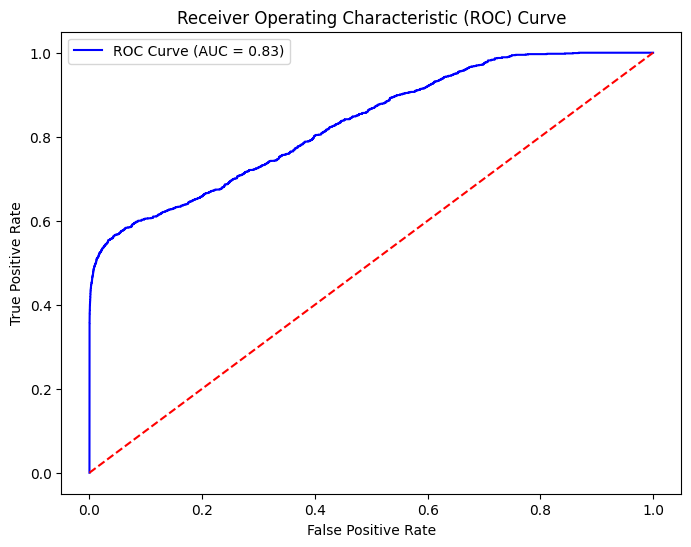

In [21]:
# ROC and AUC Section
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Plot the ROC curve
plot_roc_auc(y_val, y_pred)

In [17]:
# ROC and AUC Section
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

plot_roc_auc(y_val, y_pred)

NameError: name 'y_pred' is not defined